<head>
    <style>
        .md-typeset h2 {
            margin:0;
            }
        .md-typeset h3 {
            margin:0;
            }
        .jupyter-wrapper table.dataframe tr, .jupyter-wrapper table.dataframe th, .jupyter-wrapper table.dataframe td {
            text-align:left;
            }
        .jupyter-wrapper table.dataframe {
            table-layout: auto;
            }
    </style>
</head>

# Graphic Causal Modeling 

## The classical example: confounder 

Causal effects can happen in two ways. They can either be direct (e.g., $X \to Y$), 
or they can be mediated by a third variable (e.g., $X \to D \to Y$). When they are mediated 
by a third variable, we are capturing a sequence of events originating with, 
which may or may not be important to you depending on the question you’re asking.

<img src="/math/causal/images/dag1.png">

Controlling income could give us _identification causal path_ in the above graph.

## Discrimination and collider bias

<img src="/math/causal/images/dag2.png">

Simply controlling occupation will open another backdoor path, therefore it also introduces the bias.

Now, we will run the following simulation:

\begin{aligned}
\text{occupation} & = 1 + 2 \cdot \text{ability} - 2 \cdot \text{discrimination} + \epsilon  \\
\text{wage} & = 1 - 1 \cdot \text{discrimination} + 1 \cdot \text{occupation} + 2 \cdot \text{ability} + \epsilon 
\end{aligned}


In [ ]:
# load key packages 
library(tidyverse)
library(stargazer)
library(gridExtra)

In [10]:
tb <- tibble(
  female = ifelse(runif(10000)>=0.5,1,0),
  ability = rnorm(10000),
  discrimination = female,
  occupation = 1 + 2*ability + 0*female - 2*discrimination + rnorm(10000),
  wage = 1 - 1*discrimination + 1*occupation + 2*ability + rnorm(10000) 
)
head(tb)

female,ability,discrimination,occupation,wage
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1.0020868,1,-3.908715,-4.767657
1,0.8251398,1,2.776489,4.444233
1,-1.9626556,1,-4.219625,-7.824521
0,-1.0251509,0,-1.084414,-4.213089
1,-1.1649301,1,-3.394461,-5.257405
0,0.2716116,0,2.034413,3.382199


With the above simulated dataset, we will run different regressions. 

In [11]:
lm_1 <- lm(wage ~ female, tb)
lm_2 <- lm(wage ~ female + occupation, tb)
lm_3 <- lm(wage ~ female + occupation + ability, tb)

stargazer(lm_1,lm_2,lm_3, align=TRUE, type="text",
          column.labels = c("Biased Unconditional", 
                            "Biased",
                            "Unbiased Conditional"),
                            omit.stat=c("f", "ser"))


                            Dependent variable:                
             --------------------------------------------------
                                    wage                       
             Biased Unconditional  Biased  Unbiased Conditional
                     (1)            (2)            (3)         
---------------------------------------------------------------
female            -3.043***       0.599***      -1.008***      
                   (0.085)        (0.029)        (0.028)       
                                                               
occupation                        1.797***       0.992***      
                                  (0.006)        (0.010)       
                                                               
ability                                          2.014***      
                                                 (0.023)       
                                                               
Constant           2.000***       0.201

## Sample selection and collider bias

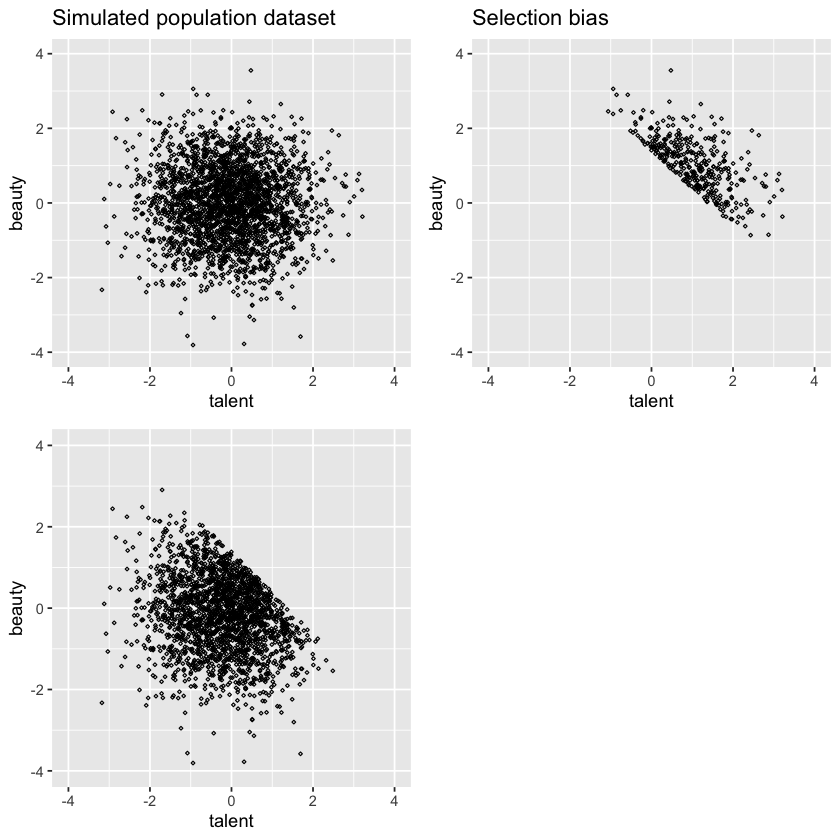

In [16]:
set.seed(3444)

star_is_born <- tibble(
  beauty = rnorm(2500),
  talent = rnorm(2500),
  score = beauty + talent,
  c85 = quantile(score, .85),
  star = ifelse(score>=c85,1,0)
)

star_is_born %>% 
  ggplot(aes(x = talent, y = beauty)) +
  geom_point(size = 0.5, shape=23) + xlim(-4, 4) + ylim(-4, 4) +
  labs(title="Simulated population dataset")-> p1

star_is_born %>% 
  filter(star == 1) %>% 
  ggplot(aes(x = talent, y = beauty)) +
  geom_point(size = 0.5, shape=23) + xlim(-4, 4) + ylim(-4, 4) +
  labs(title="Selection bias")-> p2

star_is_born %>% 
  filter(star == 0) %>% 
  ggplot(aes(x = talent, y = beauty)) +
  geom_point(size = 0.5, shape=23) + xlim(-4, 4) + ylim(-4, 4) -> p3

grid.arrange(p1, p2, p3, ncol=2)

Another example of selection bias. However, in economics, this kind of problem
is called endogeneity issue. 

<img src="/math/causal/images/dag3.png">

The type example of endogeneity issue is like the following one:

$$\text{Ice-Cream} = \beta + \alpha \text{shorts-wearing} + \epsilon$$


## Bad controls

For a detailed discussion about his topic, please read [A Crash Course in Good and Bad Controls](https://ftp.cs.ucla.edu/pub/stat_ser/r493.pdf). Here, we will just give two simulated examples. 

<img src="/math/causal/images/bad-controls.png">


In [3]:
set.seed(667)

bc1 <- tibble(
    temperature = rnorm(1000),
    income = -temperature + rnorm(1000),
    conflict = -income + rnorm(1000)
)
head(bc1)

temperature,income,conflict
<dbl>,<dbl>,<dbl>
-0.8560472,-0.8598829,1.64028907
0.7707248,-1.0750156,0.85199733
1.5739846,-1.9956509,1.49827870
0.6372712,-1.0574478,-0.49129083
-0.4718903,0.8817119,0.03996063
0.2372490,-0.2082629,0.48702977


In [6]:
lm_1 <- lm(conflict ~ temperature, bc1)
lm_2 <- lm(conflict ~ income, bc1)
lm_3 <- lm(conflict ~ temperature + income, bc1)

stargazer(lm_1,lm_2,lm_3, align=TRUE, type="text",
          column.labels = c("Reduced form", 
                            "Regress on income",
                            "Condition on a mediator"),
                            omit.stat=c("f", "ser"))


                              Dependent variable:                  
             ------------------------------------------------------
                                    conflict                       
             Reduced form Regress on income Condition on a mediator
                 (1)             (2)                  (3)          
-------------------------------------------------------------------
temperature    0.998***                              0.053         
               (0.042)                              (0.045)        
                                                                   
income                        -0.989***            -0.961***       
                               (0.023)              (0.033)        
                                                                   
Constant        -0.012         -0.011               -0.011         
               (0.043)         (0.032)              (0.032)        
                                               

In [13]:
set.seed(339)
bc2 <- tibble(
    u = rnorm(1000),
    x=2*runif(1000),
    y=x + u,
    outcome1 = x**2 + rnorm(1000),
    outcome2 = x**2 + log(x) + u + rnorm(1000)
)
head(bc2)

u,x,y,outcome1,outcome2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.14767672,1.5117346,2.65941135,2.6071567,3.2322593
-1.06238272,1.1555816,0.09319891,1.6806377,-0.6534098
-1.11620359,0.8817117,-0.23449192,-0.3929352,-0.9788538
-0.01139759,1.0892876,1.07788999,0.9562753,0.9376560
-2.49098269,1.4013026,-1.08968012,2.0937102,-1.2511413
1.91860870,0.3386069,2.25721565,-1.1623001,-0.7352300


In [15]:
lm1 <- lm(y ~ x, bc2)
lm2 <- lm(y ~ x + outcome1, bc2)
lm3 <- lm(y ~ x + outcome2, bc2)
lm4 <- lm(y ~ x + outcome1 + outcome2, bc2)

stargazer(lm1, lm2, lm3, lm4, align=TRUE, type="text",
          column.labels = c("No controls", 
                            "Good control 1",
                            "Bad control 2",
                            "Bad control 1 + 2"),
                            omit.stat=c("f", "ser"))


                                Dependent variable:                    
             ----------------------------------------------------------
                                         y                             
             No controls Good control 1 Bad control 2 Bad control 1 + 2
                 (1)          (2)            (3)             (4)       
-----------------------------------------------------------------------
x             0.967***      0.967***      -0.711***       -0.732***    
               (0.056)      (0.084)        (0.070)         (0.084)     
                                                                       
outcome1                    0.00001                         0.010      
                            (0.031)                        (0.022)     
                                                                       
outcome2                                  0.502***        0.502***     
                                           (0.017)         (0.0

## References

* [1] - [Causal Inference: the mixed tape](https://mixtape.scunning.com/03-directed_acyclical_graphs#more-examples-of-collider-bias)
* [2] - [Causal Inference Youtube Course](https://www.youtube.com/watch?v=9QJUvVB4lcI&list=PLyvUJLHD8IsJCB7ALqwjRG1BjL5JxE__H&index=2)
* [3] - [Bad Control Problem](https://ftp.cs.ucla.edu/pub/stat_ser/r493.pdf)
* [4] - [Collider Bias in Economic History Research](http://eprints.lse.ac.uk/106578/1/Schneider_Collider_Bias_in_Economic_History_Research_2020_v4.pdf)
